# Задача о пожарном ведре

Аналитическое и численное решение задач оптимизации на Python

[К оглавлению](_contents.ipynb)

## Условие задачи

Из круглого листа жести радиусом $R = 25$ см вырезается сектор. Затем оставшаяся часть сворачивается в конус, при этом точка $a$ подтягивается к точке $c$, а шов сваривается.

Требуется найти угол вырезки $\alpha$, при котором объем ведра будет максимальным. \cite{OchkovMC14}

![Задача о пожарном ведре](pics/pozhar.png)

Объем конуса:

$$ V = \frac{1}{3} \pi r^2 h $$

Длина окружности основания $L$ совпадает с длиной заготовки $abc$

$$ L = 2 \pi R \left( 1-\alpha/360 \right) $$

Зная длину окружности, можно найти радиус основания:

$$ r = \frac{L} {2 \pi} $$

Высоту конуса можно найти по теореме Пифагора:

$$ h = \sqrt{R^2 - r^2} $$

## Аналитическое решение с помощью пакета SymPy

In [2]:
# Подключение пакетов
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import scipy.optimize as opt

# Настройка способа отображения и стиля графиков
%matplotlib inline
import seaborn as sns
sns.set_context('talk')

# Включение вывода формул
init_printing()

In [159]:
# Формула для объема ведра получена с помощью аналитических преобразований в SymPy. Но получилась негуманной.
alpha, R, r, h, V = symbols('alpha, R, r, h, V')

L = 2 * pi * R * (1 - alpha/360)
r = L / (2 * pi)
h = sqrt(R**2 - r**2)
V = Rational(1, 3) * pi * r**2 * h

Функциональный вид зависимости объема от угла и радиуса:

In [160]:
Eq(symbols('V'), V)

## Анализ решения

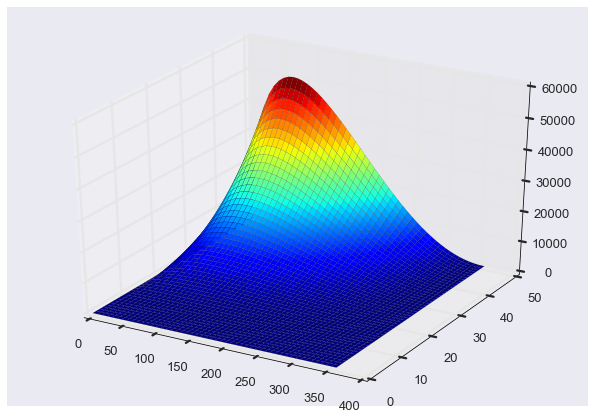

In [161]:
from sympy.plotting import plot3d
plot3d(V, (alpha, 0, 360), (R, 0, 50));

Из графика поверхности целевой функции видно, что при увеличении радиуса от 0 до 50 дм объем ведра нелинейно возрастает, однако экстремум при этом не достигается. А при изменении угла выреза объем сначала растет, а затем уменьшается, при каждом заданном значении $R$ существует выраженный экстремум.

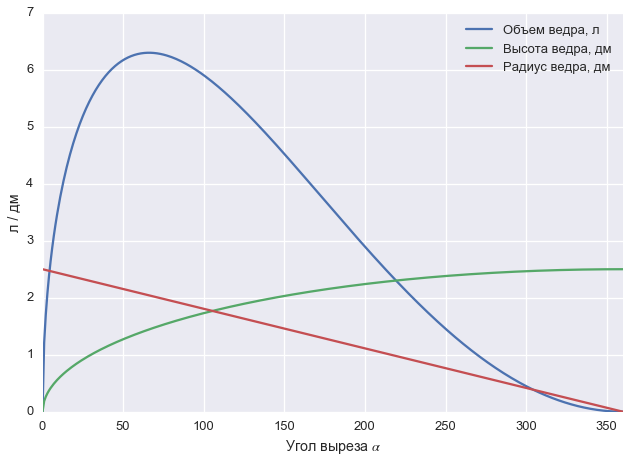

In [162]:
# Построение графика
alphas = np.linspace(0, 360, 361) #Диапазон изменения угла выреза
Volume = lambdify((alpha, R), V, 'numpy') #Получаем из выражения для объема обычную функцию
Vs = Volume(alphas, 2.5) #Рассчитываем объемы для каждого заданного значения угла. Радиус - в дм, объем - в литрах (куб.дм)
height = lambdify((alpha, R), h, 'numpy') #Получаем из выражения для высоты ведра обычную функцию
hs = height(alphas, 2.5) #Рассчитываем высоту ведра для каждого заданного значения угла
radius = lambdify((alpha, R), r, 'numpy') #Получаем из выражения для радиуса ведра обычную функцию
rs = radius(alphas, 2.5)#Рассчитываем радиус ведра для каждого заданного значения угла

plt.plot(alphas, Vs, label='Объем ведра, л')
plt.plot(alphas, hs, label='Высота ведра, дм')
plt.plot(alphas, rs, label='Радиус ведра, дм')
plt.xlabel(r'Угол выреза $\alpha$')
plt.ylabel(r'л / дм')
plt.legend(loc='best')
plt.xlim((0, 360))
plt.show()

Для нахождения экстремума функции необходимо продифференцировать ее и найти корни уравнения:

$$ \frac{\partial V}{\partial \alpha} = 0 $$

Результаты аналитического решения:

In [163]:
alphasopt = solve(V.diff(alpha), alpha) #дифференцируем по alpha и находим корни уравнения
alphasopt

Из трех корней только второй в допустимом диапазоне: $(0, 360)$
Также важно, что в формуле для вычисления точки экстремума отсутствует радиус $R$, - значит, расположение экстремума не зависит от радиуса заготовки.

In [164]:
# Выбираем оптимальный угол и рассчитываем объем
alphaopt = float(alphasopt[1].evalf()) #Численное значение координаты экстремума
Vopt = Volume(alphaopt, 2.5) #Объем ведра при оптимальном угле выреза и радиусе 2.5 дм

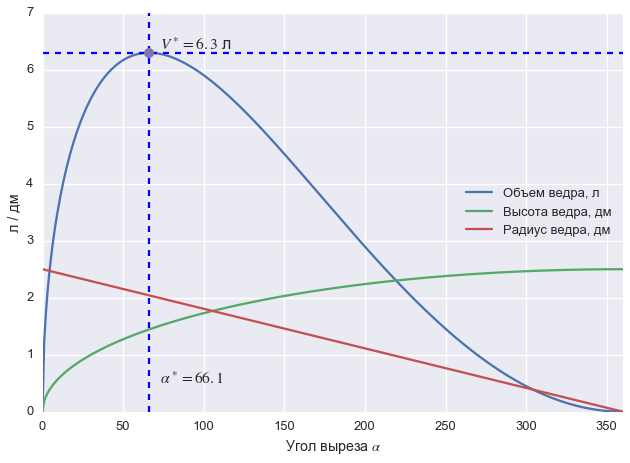

In [165]:
# Код для построения графика
plt.plot(alphas, Vs, label='Объем ведра, л')
plt.plot(alphas, hs, label='Высота ведра, дм')
plt.plot(alphas, rs, label='Радиус ведра, дм')
plt.xlabel(r'Угол выреза $\alpha$')
plt.ylabel(r'л / дм')
plt.xlim(0, 360)

# Опорные линии для оптимальной точки
plt.axvline(alphaopt, linestyle='dashed')
plt.annotate(r'$\alpha^* = %.1f$'% alphaopt, (alphaopt * 1.1, 0.5))
plt.axhline(Vopt, linestyle='dashed')
plt.annotate(r'$V^* = %.1f$ л'% Vopt, (alphaopt * 1.1, Vopt*1.01))

plt.plot(alphaopt, Vopt, 'o', ms=10)
plt.legend(loc='best')

plt.show()

## Определение точки максимума численным методом

### Метод сетки (полный перебор)

Поскольку у нас есть массив значений объема для каждого возможного угла выреза, можно просто выбрать угол, соответствующий максимальному объему:

In [166]:
print('Максимальный объем: %.1f л достигается для %d '
      'элемента массива, при этом угол выреза составляет: %d' 
          % (Vs.max(), Vs.argmax(), alphas[Vs.argmax()]))

Максимальный объем: 6.3 л достигается для 66 элемента массива, при этом угол выреза составляет: 66


Метод сетки позволяет получить координаты оптимальной точки лишь приближенно и только когда число оптимизирующих переменных невелико. Для поиска точного решения можно воспользоваться численными методами оптимизации, доступными в пакете `scipy.optimize`

### Использование функций пакета scipy.optimize

In [167]:
# Функции пакета могут только минимизировать, 
# необходимо перейти от задачи на максимум к задаче на минимум, поменяв знак целевой функции.
# Также необходимо зафиксировать заданное значение радиуса - 2.5 дм, тогда задача оптимизации будет одномерной

def Volume1d(alpha):
    return -Volume(alpha, 2.5)

res = opt.minimize_scalar(Volume1d, bounds=(0, 360), method='Bounded')
res

  status: 0
 success: True
 message: 'Solution found.'
    nfev: 11
       x: 66.061229098040101
     fun: -6.297914459146587

In [168]:
print('Оптимальное значение угла выреза составило %.1f градуса.'
      ' Потребовалось %d вычислений функции.' % (res['x'], res['nfev']))

Оптимальное значение угла выреза составило 66.1 градуса. Потребовалось 11 вычислений функции.


## Задача о двух пожарных ведрах

Пусть требуется из вырезанной части изготовить еще одно ведро. Как разрезать заготовку, чтобы получились два ведра максимального суммарного объема?

In [169]:
V2 = V + V.subs(alpha, 360-alpha)

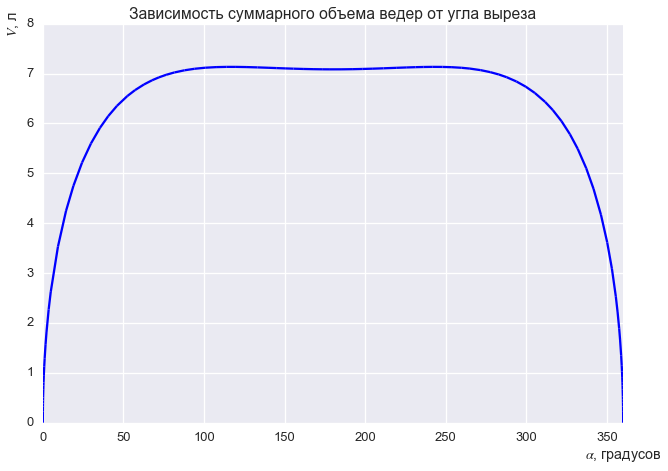

In [179]:
plot(V2.subs(R, 2.5), (alpha, 0, 360), 
     title='Зависимость суммарного объема ведер от угла выреза',
    xlabel=r'$\alpha$, градусов', ylabel='$V$, л');

In [171]:
# Попытка аналитического нахождения экстремума
solve(V2.diff(alpha), alpha)

Получен неверный ответ. Найденный экстремум - на самом деле, локальный минимум
Знак второй производной в найденной точке:

In [172]:
D2V = V2.diff(alpha, 2)
D2V = D2V.subs({alpha: 180, R: 2.5}).evalf()
print(D2V, d2V>0)

4.85950189748965e-5 True


Обратимся к численному решению, используя функции пакета scipy.optimize

In [173]:
Volume2 = lambdify((alpha, R), V2, 'numpy')

# Функция для минимизации
def Volume2_1(alpha):
    return -Volume2(alpha, 2.5)

res2a = opt.minimize_scalar(Volume2_1, bounds=(0, 180), method='Bounded')
print('Первый максимум:\n', res2a)

res2b = opt.minimize_scalar(Volume2_1, bounds=(180, 360), method='Bounded')
print('\n\nВторой максимум:\n',res2b)

alpha2opt = res2a['x']
V2opt = Volume2(alpha2opt, 2.5)

Первый максимум:
   status: 0
 success: True
 message: 'Solution found.'
    nfev: 12
       x: 116.64498647793789
     fun: -7.1350092343685709


Второй максимум:
   status: 0
 success: True
 message: 'Solution found.'
    nfev: 12
       x: 243.3550135109686
     fun: -7.13500923436857


Поскольку материал заготовки используется полностью, мы получили два эквивалентных решения. Отличаются они только тем, какое ведро будет первым, а какое - вторым.

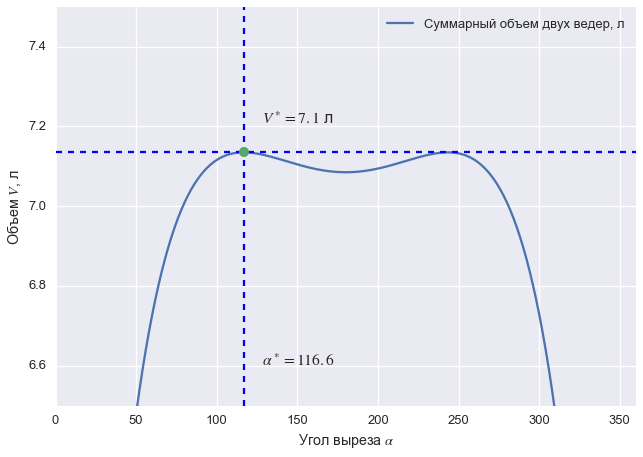

In [180]:
V2s = Volume2(alphas, 2.5)

plt.plot(alphas, V2s, label='Суммарный объем двух ведер, л')
plt.xlabel(r'Угол выреза $\alpha$')
plt.ylabel(r'Объем $V$, л')
plt.xlim(0, 360)
plt.ylim(6.5, 7.5)

# Опорные линии для оптимальной точки
plt.axvline(alpha2opt, linestyle='dashed')
plt.annotate(r'$\alpha^* = %.1f$'% alpha2opt, (alpha2opt * 1.1, 6.6))
plt.axhline(V2opt, linestyle='dashed')
plt.annotate(r'$V^* = %.1f$ л'% V2opt, (alpha2opt * 1.1, V2opt*1.01))

plt.plot(alpha2opt, V2opt, 'o', ms=10)
plt.legend(loc='best')

plt.show()

In [175]:
print('Объем первого ведра: %.1f л, второго - %.1fл' % (V.subs({alpha: alpha2opt, R:2.5}),
                                                    V.subs({alpha: 360-alpha2opt, R:2.5})))

Объем первого ведра: 5.5 л, второго - 1.6л


In [176]:
print('Радиус первого ведра: %.1f дм, второго - %.1fдм' % (r.subs({alpha: alpha2opt, R:2.5}),
                                                    r.subs({alpha: 360-alpha2opt, R:2.5})))


Радиус первого ведра: 1.7 дм, второго - 0.8дм


In [177]:
print('Высота первого ведра: %.1f дм, второго - %.1fдм' % (h.subs({alpha: alpha2opt, R:2.5}),
                                                    h.subs({alpha: 360-alpha2opt, R:2.5})))

Высота первого ведра: 1.8 дм, второго - 2.4дм


# Литература

[<a id="cit-OchkovMC14" href="#call-OchkovMC14">1</a>] В. Ф. Очков, ``_Mathcad 14 для студентов и инженеров_'',  2009.

# References

[<a id="cit-OchkovMC14" href="#call-OchkovMC14">1</a>] В. Ф. Очков, ``_Mathcad 14 для студентов и инженеров_'',  2009.

